In [1]:
import torch
import torch.nn as nn


class XTinyUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1, img_size=(256, 256), init_filters=4, max_filters=4, deep_supervision=True):
        super(XTinyUNet, self).__init__()
        
        num_stages = 7 if max(img_size) <= 256 else 8
        filters = [min(max_filters, init_filters * 2**i) for i in range(num_stages)]
        # filters = [2, 4, 8, 16, 16, 16, 16]
        
        self.encoder = XTinyEncoder(in_channels, filters, deep_supervision=deep_supervision)
        self.decoder = XTinyDecoder(self.encoder, num_classes, filters, deep_supervision)

    def forward(self, x):
        x, skip_connections = self.encoder(x)
        x = self.decoder(x, skip_connections)
        return x


class XTinyEncoder(nn.Module):
    def __init__(self, in_channels=1, filters=[], deep_supervision=True):
        super(XTinyEncoder, self).__init__()
        
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, filters[0], kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(filters[0], eps=1e-05, momentum=0.1, affine=True, track_running_stats=False),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

        stages = []
        pooling_layers = []

        num_stages = len(filters)
        for i in range(num_stages):            
            # Conv Block
            block = nn.Sequential(
                nn.Conv2d(filters[i], filters[i], kernel_size=3, stride=1, padding=1),
                nn.InstanceNorm2d(filters[i], eps=1e-05, momentum=0.1, affine=True, track_running_stats=False),
                nn.LeakyReLU(negative_slope=0.01, inplace=True)
            )
            stages.append(nn.Sequential(block, block))

            if i < num_stages - 1:
                # Pooling Block
                pooling_layers.append(nn.Conv2d(filters[i], filters[i+1], kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
        
        self.stages = nn.ModuleList(stages)
        self.pooling_layers = nn.ModuleList(pooling_layers)

    def forward(self, x):
        x = self.stem(x)
        skip_connections = []
        for i, stage in enumerate(self.stages):
            x = stage(x)
            skip_connections.append(x)
            print(f"Stage {i+1} output shape: {x.shape}")
            if i < len(self.stages) - 1:
                x = self.pooling_layers[i](x)
        return x, skip_connections


class XTinyDecoder(nn.Module):
    def __init__(self, encoder, num_classes=2, filters=[], deep_supervision=True):
        super(XTinyDecoder, self).__init__()
        
        self.deep_supervision = deep_supervision
        stages = []
        num_stages = len(encoder.stages)
        transpose_convs = []
        ds_seg_heads = []
        for i in range(1, num_stages):
            stages.append(nn.Sequential(
                nn.Conv2d(filters[-(i+1)]*2, filters[-(i+1)], kernel_size=3, stride=1, padding=1),
                nn.InstanceNorm2d(filters[-(i+1)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=False),
                nn.LeakyReLU(negative_slope=0.01, inplace=True)
            ))

            transpose_convs.append(nn.ConvTranspose2d(filters[-i], filters[-(i+1)], kernel_size=2, stride=2))
            
            ds_seg_heads.append(nn.Sequential(
                nn.Conv2d(filters[-(i+1)], num_classes, kernel_size=1, stride=1)
            ))
        
        self.stages = nn.ModuleList(stages)
        self.transpose_convs = nn.ModuleList(transpose_convs)
        self.ds_seg_heads = nn.ModuleList(ds_seg_heads)

    def forward(self, x, skip_connections):
        outputs = []
        for i in range(len(self.stages)):
            print(f"x dec input shape: {x.shape}")
            x = self.transpose_convs[i](x)
            print(f"x transpose conv shape: {x.shape}")
            print(f"skip_connections[-(i+1)] shape: {skip_connections[-(i+2)].shape}")
            x = torch.cat([x, skip_connections[-(i+2)]], dim=1)
            print(f"x cat shape: {x.shape}")
            x = self.stages[i](x)
            print(f"x stage shape: {x.shape}")
            outputs.append(self.ds_seg_heads[i](x))
            print(f"x ds seg head shape: {x.shape}")
        
        if self.deep_supervision:
            return outputs
        else:
            return outputs[-1]


In [2]:
x = torch.randn((1,1,256,256))
model = XTinyUNet(in_channels=1, num_classes=2, img_size=(256, 256), deep_supervision=True)
print(model)
for output in model(x):
    print(output.shape)

XTinyUNet(
  (encoder): XTinyEncoder(
    (stem): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (stages): ModuleList(
      (0-6): 7 x Sequential(
        (0): Sequential(
          (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (pooling_layers): ModuleList(
      (0-5): 6 x Conv2d(4, 4, kernel_size=(3, 3), stride=(2,

In [3]:
# total params
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")

Total params: 4,296


/home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw/Dataset072_GE_LQP9/imagesTr/Nike_Olivia___NIKE_S951_T3_L_CAR_2_1500_0000.png
input shape (412, 417)
input shape torch.Size([1, 1, 412, 417])


Mono2DV3(in_channels=1, out_channels=3, in_channels=1, out_channels=1, nscale=3, norm=std, return_phase=True, trainable=True)
[[10.944469451904297, 27.361173629760742, 68.4029312133789]]
2.5

output shape torch.Size([3, 412, 417])


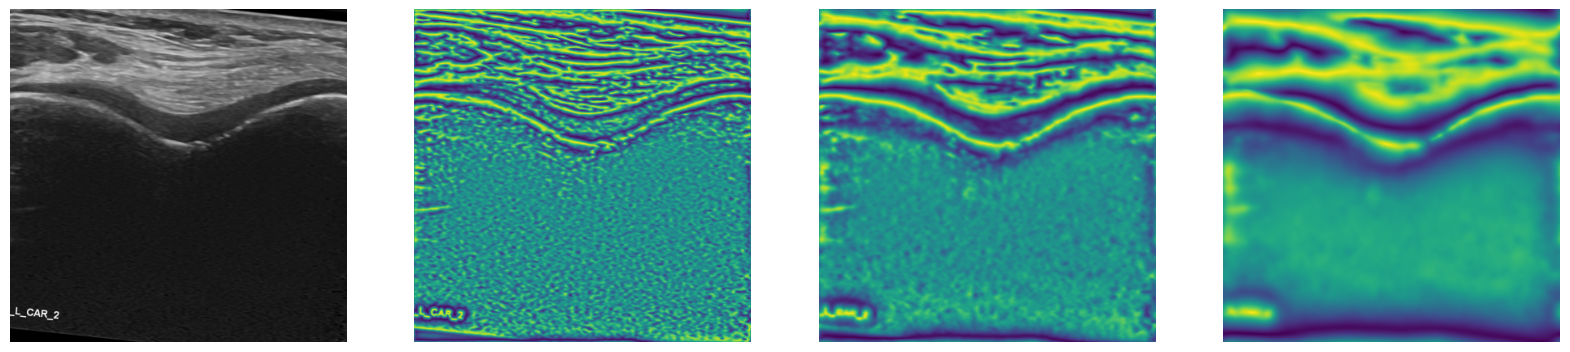

In [131]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mono_layer import Mono2DV3
from PIL import Image
from pprint import pprint
from glob import glob

img_paths = glob("/home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw/Dataset07*/imagesTr/*.png")
random.shuffle(img_paths)
img_path = img_paths[0]
print(img_path)
input = Image.open(img_path)
input = np.array(input)
print("input shape", input.shape)
input = torch.tensor(input).unsqueeze(0).unsqueeze(0)
print("input shape", input.shape)
print("\n")

model = Mono2DV3(in_channels=1, nscale=3)
print(model)

pprint(model.get_params()['wls'])
pprint(model.get_params()['factor'])

output = model(input).squeeze(0)
print("\noutput shape", output.shape)

plt.figure(figsize=(20, 13))
plt.subplot(1, 4, 1)
plt.imshow(input.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')
for i, o in enumerate(output):
    plt.subplot(1, 4, i+2)
    plt.imshow(o.detach().cpu().numpy())
    plt.axis('off')
plt.show()